In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.fftpack as sf
import scipy.constants as sc

In [19]:
R_ref = 1000e+3
Vr = 7100
Tr = 40e-6
Kr = 0.5e+12
f0 = 5.3e+09

Fr = 24e+6 
Fa = 1700
# delta_fdop = 1338
theta_sqc = 8*np.pi/180

Ta = 0.64

La = 10

In [20]:
Vs = Vr*1.06
Vg = Vr*0.94
theta_rc = np.arcsin(np.sin(theta_sqc)*Vr/Vg)
f_etac = 2*Vr*np.sin(theta_rc)*f0/sc.c
theta_bw = 0.886*sc.c/f0/La
Naz = Ta*Fa
Nrg = Tr*Fr

delta_fdop = 2*Vs*np.cos(theta_rc)/sc.c*f0*theta_bw
print('f_etac:',f_etac)
print('delta_fdop:',delta_fdop)

R_0 = R_ref + 20e+3             #零多普勒面斜距
R_etac = R_0/np.cos(theta_rc)
eta_c = -R_0*np.tan(theta_rc)/Vr
N_az = int(2*Naz)
N_rg = int(2*Nrg)

eta = np.linspace(-Ta, Ta - 1/Fa, N_az)
tau = np.linspace(-Tr, Tr - 1/Fr, N_rg) 
eta = eta.reshape(N_az,1)
tau = tau.reshape(1,N_rg)

eta_array = eta + eta_c

print('R_etac:',R_etac,'eta_c:',eta_c)
print(N_az,N_rg,f_etac,theta_rc*180/np.pi)

f_etac: 37168.15139568393
delta_fdop: 1318.9093891115656
R_etac: 1031366.7907969796 eta_c: -21.507119344088505
2176 1920 37168.15139568393 8.514314090791315


点目标示意图

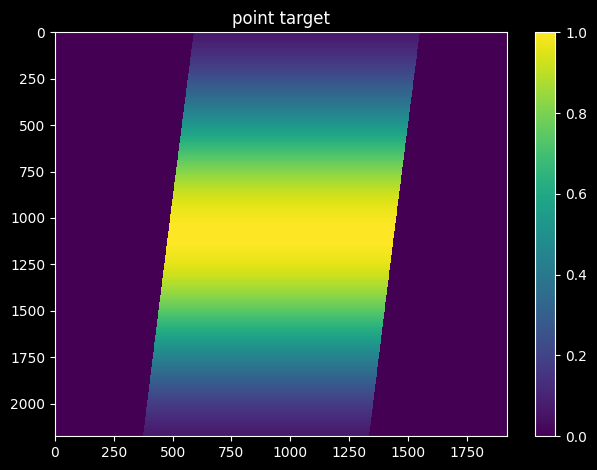

In [21]:
R_eta = np.sqrt(R_0**2 + (Vr*(eta_array))**2)  
rectan_rg = (np.abs(tau-2*(R_eta-R_etac)/sc.c)<=Tr/2)

#eta_array = eta + eta_c为图像方位向时间跨度, eta_c为实际图像波束中心时间
#tau + 2*R_etac/sc.c为图像距离向时间跨度, R_etac为对应点目标中心距离向时间
S_2d= rectan_rg*np.sinc(0.886*np.arctan(Vr*(eta_array-eta_c)/R_0)/theta_bw)**2*np.exp(-1j*4*np.pi*R_eta*f0/sc.c)\
          *np.exp(1j*np.pi*Kr*(tau-2*(R_eta-R_etac)/sc.c)**2)       #center :(eta_c, R_etac)


plt.figure()
plt.pcolormesh(np.abs(S_2d))
bottom,top = plt.ylim()
plt.ylim(top,bottom)
plt.title('point target')
plt.colorbar()
plt.tight_layout()
plt.show()

参考函数

In [22]:
N_azimuth_fft = N_az
N_range_fft = N_rg
f_rg = np.fft.fftshift(np.linspace(-Fr/2, Fr/2 - Fr/N_range_fft, N_range_fft))
f_rg -= np.round((f_rg - 0) / Fr) * Fr
f_azi = np.fft.fftshift(np.linspace(-Fa/2, Fa/2 - Fa/N_azimuth_fft, N_azimuth_fft))
f_azi += np.round((-f_azi+f_etac)/Fa)*Fa

f_rg = f_rg.reshape(1,N_range_fft)
f_azi = f_azi.reshape(N_azimuth_fft, 1)
H_azi_shift = 1
# H_azi_shift = np.exp(-1j*2*np.pi*(f_azi*eta_c))


range_pixel = sc.c/Fr/2
#需要考虑H_theta_ref在距离向上将点目标压缩的位置是否在R_etac
# H_theta_ref 将目标压缩至R_etac - R_theta_ref/cos(theta_rc)时间处，R为其中的距离参数
R_theta_ref = R_ref
H_theta_ref = np.exp(1j*4*np.pi*(R_theta_ref)/sc.c*np.sqrt((f0+f_rg)**2 - (sc.c*f_azi/2/Vr)**2) + 1j*np.pi*f_rg**2/Kr)
S_2df = sf.fft2(sf.ifft(sf.fft(S_2d,axis=0)*H_azi_shift,axis=0))
#距离向是为了将压缩位置移动至景中心，方位向是为了将压缩位置移动至e_tac处
H_linear = 1
# H_linear = np.exp(-1j*2*np.pi*(f_rg*(2*(R_theta_ref/np.cos(theta_rc))/sc.c)))
# H_linear = np.exp(-1j*2*np.pi*(f_rg*tau[0,int(N_rg/2)]))*np.exp(-1j*2*np.pi*f_azi*eta_array[int(N_az/2),0])
S_2df_theta_ref = S_2df*H_theta_ref*H_linear

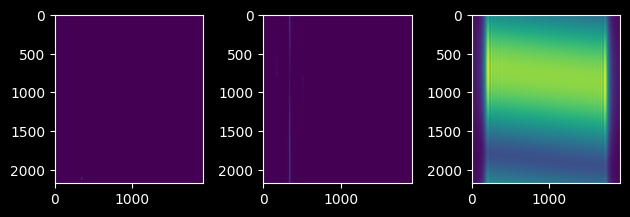

In [23]:

S_ori = sf.ifft2(S_2df_theta_ref)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(np.abs(S_ori))
plt.subplot(1,3,2)
S_rdf_theta_ref = sf.ifft(S_2df_theta_ref,axis=1)
plt.imshow(np.abs(S_rdf_theta_ref))
plt.subplot(1,3,3)
plt.imshow(np.abs(np.fft.fftshift(S_2df_theta_ref)))
plt.tight_layout()
plt.show()

# print((np.fft.fftshift(S_2df_theta_ref))[:5,:5])
# print(((S_2df_theta_ref))[:5,:5])

Stolt插值

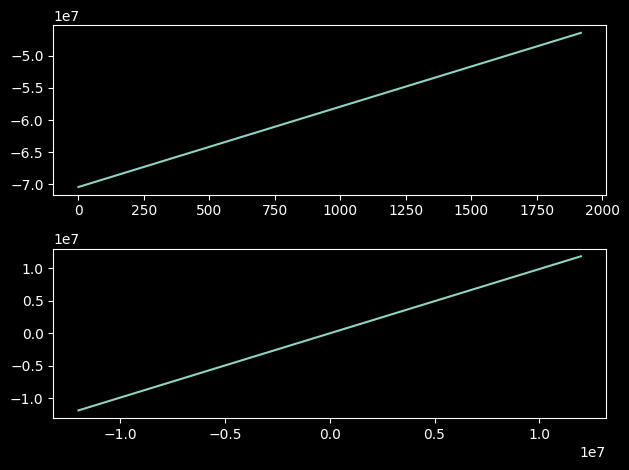

In [24]:
#最终的结果在不考虑方位向线性相位的情况下，应该是每一列的相位都是一致的，每一行的相位都是线性的
#又知道f_rg(f_eta=0)的stolt为恒等变换，且该行相位是线性的，所以stolt插值的目的是使得其余行的相位均与f_rg(f_eta=0)这一行一致
#由上得：
# 1. stolt变化后的距离向频率轴的范围仍为f_rg(f_eta=0)
# 2. 其余行的频率轴是对于stolt变换的频率在f_rg(f_eta=0)范围的缠绕，所以需要前2步得到真实的f_stolt
# 3. 基于真实的f_stolt，第3步得到了f_stolt变换前对于的频率范围
#总结：变换前后的距离向频率轴的范围不变，与f_rg(f_eta=0)一致，基于这个事实，其余行的频率范围需要发生对应的改变，对应的数据需要进行对应的插值平移

f_rg_shift = np.fft.fftshift(f_rg,axes=1)
f_stolt_c = np.sqrt((f0+0)**2-(sc.c*f_azi/(2*Vr))**2) - f0                      #计算插值后的距离向中心频率
f_rg_stolt = f_stolt_c + f_rg_shift        
# f_rg_stolt = f_rg_shift + np.round((-f_rg_shift + f_stolt_c) / Fr) * Fr       #得到(f_stolt_c - Fr/2, f_stolt_c + Fr/2),实际的f_stolt
f_rg_2 = np.sqrt((f0+f_rg_stolt)**2+(sc.c*f_azi/(2*Vr))**2) - f0                #实际的stolt映射前的频率轴
etac_index = np.argmin(np.abs(f_azi - f_etac))
f_rg_2_etac = np.sqrt((f0+f_rg_stolt[etac_index,:])**2+(sc.c*f_azi/(2*Vr))**2) - f0   #相对于中心多普勒频点处stolt映射前的距离向频率轴
# print(f_rg[0,:5])
# print(f_rg_2[0,:5])
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(N_range_fft),f_rg_stolt[etac_index,:])
plt.subplot(2,1,2)
plt.plot(f_rg_shift[0,:],f_rg_2_etac[etac_index,:])
plt.tight_layout()
plt.show()


In [28]:
interp_num = 8
interp_step = 16
N_pad = 1024
# interp_pos = np.linspace(0,1-1/interp_step,interp_step)
interp_pos = np.linspace(0,1-1/interp_step,interp_step)
interp_ind = np.arange(-interp_num/2,interp_num/2,1)
interp_xvalue = interp_ind.reshape(1,interp_num) - interp_pos.reshape(interp_step,1)
interp_sinc = np.sinc(interp_xvalue)
window = ss.get_window(window=('kaiser',0),Nx=interp_num).reshape(1,interp_num)
interp_sinc *= window
interp_sinc /= np.sum(interp_sinc, axis=1, keepdims=True) 
print(interp_sinc)

[[-3.89817183e-17  3.89817183e-17 -3.89817183e-17  3.89817183e-17
   1.00000000e+00  3.89817183e-17 -3.89817183e-17  3.89817183e-17]
 [ 1.50513609e-02 -1.99660910e-02  2.96466200e-02 -5.75493212e-02
   9.78338461e-01  6.52225640e-02 -3.15593052e-02  2.08157119e-02]
 [ 2.86503577e-02 -3.78184722e-02  5.56154003e-02 -1.05051312e-01
   9.45461806e-01  1.35065972e-01 -6.30307870e-02  4.11070350e-02]
 [ 4.04204242e-02 -5.31013416e-02  7.73762406e-02 -1.42535180e-01
   9.02722807e-01  2.08320648e-01 -9.33851179e-02  6.01815204e-02]
 [ 5.00882897e-02 -6.55000712e-02  9.46112139e-02 -1.70300185e-01
   8.51500925e-01  2.83833642e-01 -1.21642989e-01  7.74091750e-02]
 [ 5.74742812e-02 -7.48250076e-02  1.07181768e-01 -1.88844067e-01
   7.93145081e-01  3.60520491e-01 -1.46878719e-01  9.22261722e-02]
 [ 6.24804107e-02 -8.09931250e-02  1.15095493e-01 -1.98801307e-01
   7.28938125e-01  4.37362875e-01 -1.68216490e-01  1.04134018e-01]
 [ 6.50783194e-02 -8.40101941e-02  1.18475915e-01 -2.00893943e-01
   

In [29]:

# interp_num = 8
S_2df_theta_ref_2 = np.zeros_like(S_2df_theta_ref)
S_2df_theta_ref_shift = np.fft.fftshift(S_2df_theta_ref,axes=1)
# N_pad = 8
S_2df_theta_ref_2_pad = np.zeros([S_2df_theta_ref_shift.shape[0],N_pad+S_2df_theta_ref_shift.shape[1]],dtype=np.complex128)
S_2df_theta_ref_2_pad[:,0:int(N_pad/2)] = 0
S_2df_theta_ref_2_pad[:,S_2df_theta_ref_shift.shape[1]+int(N_pad/2):N_pad+S_2df_theta_ref_shift.shape[1]] = 0
S_2df_theta_ref_2_pad[:,int(N_pad/2):S_2df_theta_ref_shift.shape[1]+int(N_pad/2)] = S_2df_theta_ref_shift
window = ss.get_window(window=('kaiser',0),Nx=interp_num).reshape(1,interp_num)
Delta_f_stolt  = -(f_rg_2_etac - f_rg_shift)/(Fr/N_range_fft)
print(Delta_f_stolt[etac_index-5:etac_index,:5])
print(Delta_f_stolt[:5,:5],'\n',np.max(Delta_f_stolt),'\n',np.min(Delta_f_stolt))
print('interp...')
for i in range(Delta_f_stolt.shape[0]):
    for j in range(Delta_f_stolt.shape[1]):
        points = int(np.floor(Delta_f_stolt[i,j]))
        offset = int(np.round((Delta_f_stolt[i,j] - np.floor(Delta_f_stolt[i,j]))*interp_step))
        points += offset//interp_step
        offset = np.remainder(offset,interp_step)
        S_2df_theta_ref_2[i,j] = np.sum(S_2df_theta_ref_2_pad[i,int(N_pad/2)+j+points-int(interp_num/2):int(N_pad/2)+j+points+int(interp_num/2)]*interp_sinc[offset,:])
        # points = int(np.floor(Delta_f_stolt[i,j]))
        # offsets = Delta_f_stolt[i,j] - points
        # interp_sinc = np.sinc(np.array(range(interp_num))-int(interp_num/2)-offsets+1)
        # S_2df_theta_ref_2[i,j] = np.sum(S_2df_theta_ref_2_pad[i,int(N_pad/2)+j+points-int(interp_num/2):int(N_pad/2)+j+points+int(interp_num/2)]*interp_sinc*window)

[[ -9.6250762   -9.61400773  -9.60293931  -9.59187095  -9.58080263]
 [ -9.82085743  -9.8097885   -9.79871963  -9.7876508   -9.77658203]
 [-10.01664269 -10.0055733   -9.99450397  -9.98343469  -9.97236546]
 [-10.21243197 -10.20136212 -10.19029233 -10.17922259 -10.16815291]
 [-10.40822527 -10.39715497 -10.38608472 -10.37501453 -10.36394438]]
[[-68.93392228 -68.92271519 -68.91150815 -68.90030117 -68.88909423]
 [-69.13091881 -69.11971125 -69.10850375 -69.09729631 -69.08608891]
 [-69.32791935 -69.31671134 -69.30550338 -69.29429547 -69.28308762]
 [-69.52492392 -69.51371545 -69.50250703 -69.49129866 -69.48009035]
 [-69.72193252 -69.71072358 -69.6995147  -69.68830588 -69.6770971 ]] 
 220.05983785049438 
 -226.01476976715088
interp...


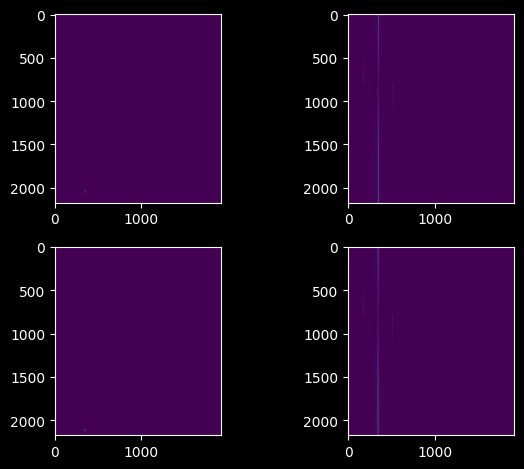

In [30]:
S_2df_theta_ref_2 = np.fft.fftshift(S_2df_theta_ref_2,axes=1)
H_linear = np.exp(-1j*2*np.pi*(f_rg*(2*(R_theta_ref/np.cos(theta_rc))/sc.c)))

S_stolt = sf.ifft2(S_2df_theta_ref_2)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.abs(S_stolt))
plt.subplot(2,2,2)
S_rdf_stolt = sf.ifft(S_2df_theta_ref_2,axis=1)
plt.imshow(np.abs(S_rdf_stolt))
plt.subplot(2,2,3)
plt.imshow(np.abs(S_ori))
plt.subplot(2,2,4)
S_rdf_stolt = sf.ifft(S_2df_theta_ref_2,axis=1)
plt.imshow(np.abs(S_rdf_theta_ref))
plt.tight_layout()
plt.show()